# Libraries
Below we import the libraries we will use later and download bla bla

In [ ]:
import os
import re
import string
from typing import Optional, Tuple, Literal, Any
from functools import partial

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm

import inflect
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score, normalized_mutual_info_score,
    v_measure_score, fowlkes_mallows_score
)

from umap import UMAP

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/leonardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/leonardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/leonardo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/leonardo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Data, Regex and Functions
Below we do the following:
- Import the data
- Compile RegeX patterns
- create inflect engine to convert numbers to words
- import the Porter Stemmer (to explain why we do not use Lancaster or Snowball) and Lemmatizer 

In [2]:
df = pd.read_csv('dataset/imdb_text2vec.csv')
# regex
YEAR_RE = re.compile(r"\b((?:18|19|20)\d{2}|[1-9]0['’]?s)\b")         
RATING_RE = re.compile(r'\b\d*(?:\.\d+)?\s*/\s*(?:5|10|100)\b')
NUM_RE = re.compile(r'\b\d+(\.\d+)?\b')
SPACES_RE = re.compile(r'\s*([?!.,]+(?:\s+[?!.,]+)*)\s*') #ciao,bella -> ciao, bella
HTML_RE = re.compile(r"<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>")
# other
p = inflect.engine()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# filter for charts and excels
qmd = False

df.columns

Index(['id', 'sentiment', 'review'], dtype='object')

# Functions
Here we create the core functions for our work, these are inspired from some aricles of Geek for Geeks - references at the bottom of the file. Some of these functions will be explained later as we use them, but for further details read their description. Kind of functions:
- convert numbers
- remove punctuations
- fix html and spaces
- remove stopwords
- lematization, stemming, POS tagging
- processing df: we gather our selected cleaning procedure in a unique function


In [ ]:

def _convert_nums(text:str,
        mx_splt_num:int = 1) -> str:

    '''
    We can also convert the numbers into words.
    This can be done by using the inflect library.
    
    mx_num_split, we do not want conversions, like 100-> one hundred,
    so we set the maximum number of words
    '''

    # assign <RATING>
    text = re.sub(RATING_RE,'<RATING>',text)
    #assign <YEAR> for 80s,90's, 1990...
    text = re.sub(YEAR_RE,'<YEAR>',text)

    # convert numbers below a threshold to string
    temp_str = text.split()
    new_string = []

    for w in temp_str:

        n2w = p.number_to_words(w) # if not a number(e.g. dog) it returns 'zero'
        cond = (w.isdigit()) and (len(n2w.split())<=mx_splt_num)
        
        to_append = n2w if cond else w
        new_string.append(to_append)

    # Other Numbers become <NUM>
    text = re.sub(NUM_RE,'<NUM>',' '.join(new_string))

    return text


def _remove_simple(text:str) -> str:

    """Does simple cleaning of HTML, and no spaces after commas"""

    # remove html patterns
  
    text = re.sub(HTML_RE, '', text)

    # remove issues like: ciao,bella
    text = SPACES_RE.sub(lambda x: "{} ".format(x.group(1).replace(" ", "")), text)

    return text


def _remove_punct(text:str,
                  to_keep:Optional[str] = "") -> str:
    '''
    We remove punctuations so that we don't have different forms of the same word.

    '''
    punctuation = ''.join(ch for ch in string.punctuation if ch not in to_keep)
    translator = str.maketrans('', '', punctuation)

    return text.translate(translator)


def _remove_stopwords(text:str,
                      other_stopwords:list[str]|str = ['movie','film'],
                      to_keep:list[str]|str = None,
                      lst_output:bool=False) -> list[str]:

    '''
    Stopwords are words that do not contribute much to the meaning of a sentence
    hence they can be removed. The NLTK library has a set of 
    stopwords and we can use these to remove stopwords from our text.     
    '''
    
    stop_words = set(stopwords.words("english"))

    if other_stopwords: stop_words.update(set(other_stopwords))
    if to_keep: stop_words.discard(set(to_keep))

    word_tokens = word_tokenize(text)
    clean = [w for w in word_tokens if not w.lower() in stop_words]
    return clean if lst_output else ' '.join(clean)

    
def _stem_words(text:list[str]|str,
                lst_output:bool=True) -> list[str]:
    '''
    Stemming is the process of getting the root form of a word.
    Stem or root is the part to which affixes like -ed, -ize, -de, -s, etc are added.
    The stem of a word is created by removing the prefix or suffix of a word.
    
    '''
    word_tokens = text if isinstance(text,list) else word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems if lst_output else ' '.join(stems)


def _lemma_words(text:str,
                 lst_output:bool=True) -> list[str]:
    '''
    Lemmatization is an NLP technique that reduces a word to its root form.
    This can be helpful for tasks such as text analysis and search as it
    allows us to compare words that are related but have different forms.

    combines pos_tagging with wordnet_pos for better lemma
    
    '''

    iterable = _pos_tagging(text)

    lemmas = [lemmatizer.lemmatize(w,_get_wordnet_pos(p)) for w, p in iterable]

    return lemmas if lst_output else ' '.join(lemmas)


def _pos_tagging(text):
    '''
    POS tagging is the process of assigning each word in a sentence its grammatical category,
    such as noun, verb, adjective or adverb. It helps machines understand the structure 
    and meaning of text, enabling tasks like parsing, information extraction and text analysis.

    NNP: Proper noun
    NN: Noun (singular)
    VBZ: Verb (3rd person singular)
    CC: Conjunction


    '''
    word_tokens = word_tokenize(text)
    return pos_tag(word_tokens)


def _get_wordnet_pos(treebank_tag):

    '''
    Get wordnet positioning: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    '''

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  #default


def preprocess_df(df:pd.DataFrame
                  ) -> pd.DataFrame:
    '''
    Perform cleaning on reviews:
    https://www.geeksforgeeks.org/machine-learning/text-preprocessing-in-python-set-1/

    '''
    # 0.  x.lower().split() -> lower case and remove extra spaces,
    # also number conversion (see above)
    df['num_clean'] = df['review'].apply(lambda x: _convert_nums(" ".join(x.lower().split())))

    # 1 remove html and ciao,bella->ciao, bella
    df['first_l_cl'] = df['num_clean'].apply(lambda x: _remove_simple(x))

    # 2 remove punctuation
    df['sec_l_cl'] = df['first_l_cl'].apply(lambda x: _remove_punct(x))

    # 3 remove stopwords 
    df['no_stopw'] = df['sec_l_cl'].apply(lambda x: _remove_stopwords(x,lst_output= False))

    # 4a lemmas 
    df['lemmas'] = df['no_stopw'].apply(lambda x: _lemma_words(x, lst_output=True))

    return df    

# Dataset clearning steps
Our function preprocess_df, picks up the main cleaning steps in the following order
1. We set to lower case and remove unnecessary blanks
2. we convert numbers to strings if below 100, ratings (e.g. 7.5/10,60/100) become < RATING > while expression of years (e.g. 80s/2000) become < YEAR >, while other numbers becoome < NUM > so that we do not loose information
3. Upon taking care of numbers, we do a simple clearning to fix some issues: such as html words (e.g. <\b>) and to add forgotten blanks after commas.
4. We can now remove the whole punctuations
5. We remove stopwords
6. we can apply lemmatisation or stemming

In [ ]:
if qmd:
    cleaned = pd.read_csv('dataset/cleaned_df.csv')
else:
    cleaned = preprocess_df(df)
    cleaned.to_csv('dataset/cleaned_df.csv')


cleaned.head(15)

,id,sentiment,review,num_clean,first_l_cl,sec_l_cl,no_stopw,lemmas,stem
0,5814_8,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...,with all this stuff going down at the moment w...,with all this stuff going down at the moment w...,stuff going moment mj ive started listening mu...,"[stuff, go, moment, mj, ive, start, listen, mu...","[stuff, go, moment, mj, ive, start, listen, mu..."
1,2381_9,1,"\""The Classic War of the Worlds\"" by Timothy H...","\""the classic war of the worlds\"" by timothy h...","\""the classic war of the worlds\"" by timothy h...",the classic war of the worlds by timothy hines...,classic war worlds timothy hines entertaining ...,"[classic, war, world, timothy, hines, entertai...","[classic, war, world, timothi, hine, entertain..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager (nicholas bell)...,the film starts with a manager (nicholas bell)...,the film starts with a manager nicholas bell g...,film starts manager nicholas bell giving welco...,"[film, start, manager, nicholas, bell, give, w...","[film, start, manag, nichola, bell, give, welc..."
3,3630_4,0,It must be assumed that those who praised this...,it must be assumed that those who praised this...,it must be assumed that those who praised this...,it must be assumed that those who praised this...,must assumed praised film greatest filmed oper...,"[must, assume, praised, film, great, film, ope...","[must, assum, prais, film, greatest, film, ope..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy and wondrously unpretentious <...,superbly trashy and wondrously unpretentious ...,superbly trashy and wondrously unpretentious ...,superbly trashy wondrously unpretentious explo...,"[superbly, trashy, wondrously, unpretentious, ...","[superbl, trashi, wondrous, unpretenti, exploi..."
5,8196_8,1,I dont know why people think this is such a ba...,i dont know why people think this is such a ba...,i dont know why people think this is such a ba...,i dont know why people think this is such a ba...,dont know people think bad movie got pretty go...,"[dont, know, people, think, bad, movie, get, p...","[dont, know, peopl, think, bad, movi, got, pre..."
6,7166_2,0,"This movie could have been very good, but come...","this movie could have been very good, but come...","this movie could have been very good, but come...",this movie could have been very good but comes...,movie could good comes way short cheesy specia...,"[movie, could, good, come, way, short, cheesy,...","[movi, could, good, come, way, short, cheesi, ..."
7,10633_1,0,I watched this video at a friend's house. I'm ...,i watched this video at a friend's house. i'm ...,i watched this video at a friend's house. i'm ...,i watched this video at a friends house im gla...,watched video friends house im glad waste mone...,"[watch, video, friend, house, im, glad, waste,...","[watch, video, friend, hous, im, glad, wast, m..."
8,319_1,0,"A friend of mine bought this film for 1, and e...","a friend of mine bought this film for <NUM>, a...","a friend of mine bought this film for, and eve...",a friend of mine bought this film for and even...,friend mine bought film even grossly overprice...,"[friend, mine, buy, film, even, grossly, overp...","[friend, mine, bought, film, even, grossli, ov..."
9,8713_10,1,<br /><br />This movie is full of references. ...,<br /><br />this movie is full of references. ...,"this movie is full of references. like \""mad m...",this movie is full of references like mad max ...,movie full references like mad max ii wild one...,"[movie, full, reference, like, mad, max, ii, w...","[movi, full, refer, like, mad, max, ii, wild, ..."


# Analysis

In [5]:
# TR: word2vec TF-IDF: https://www.geeksforgeeks.org/python/python-word-embedding-using-word2vec/

# Models Setup 

To perform text clustering, we implemented a modular Python pipeline that standardises preprocessing, model selection, and training across multiple unsupervised methods.
The main components are _clusterSelection, _modelPreprocessing, and dct_MLmodels, which together ensure reproducibility and comparability between models.

## Model selection

The _clusterSelection() function dynamically returns an instance of the selected clustering algorithm given a model name and a number of clusters.

We implemented the following models :

- K-Means (VKM) – a vector-space clustering baseline using cosine-normalised TF-IDF features.

- Gaussian Mixture Models (GMM) – a probabilistic clustering method optimised via the Expectation–Maximisation algorithm, initialised with K-Means centroids.

- Latent Dirichlet Allocation (LDA) – a probabilistic topic-modeling technique based on word counts, representing each document as a mixture of latent topics.

- Non-negative Matrix Factorisation (NMF) – a matrix-decomposition approach on TF-IDF inputs, producing interpretable topic–term and document–topic matrices.

Each model was configured with stable and interpretable hyperparameters: deterministic initialisation, consistent random seeds, and sufficient iteration limits (up to 2000 for NMF) to ensure convergence.

## Text preprocessing

The _modelPreprocessing() function applies model-specific text vectorisation before training:

Reviews were first tokenised and lemmatised (column lemmas).

Both TF-IDF and CountVectorizer representations were prepared using consistent vocabulary settings (max_features=5000, min_df=2, max_df=0.9).

LDA uses count vectors, while NMF, K-Means, and GMM use TF-IDF features.
Optionally, Truncated SVD (200 components) is applied for dimensionality reduction to speed up dense models like GMM. According to our research the SVD is very good especially with sparse matrixes such as the TFIDF.

## Model fitting and storage

The dct_MLmodels() function trains each model for k=2 to k=10 clusters and stores results in a structured dictionary (dct_models).
For each configuration, the function saves:

- the fitted model object,

- predicted cluster labels,

- the dense feature representation,

- ground-truth sentiment labels,

- for GMM also AIC and BIC, useful for comparing model complexity and goodness-of-fit.

This design allows consistent downstream evaluation (e.g., internal/external validation metrics, interpretability analysis, and UMAP visualisation) while maintaining a high level of code clarity and computational reproducibility.

In [ ]:

def _clusterSelection(model:Literal["LDA","NMF",'VKM', 'GMM'],
                      k:int = None,
                      rs_seed:int=1
                      ) -> Any:
    """
    Return the clustering model object and its Optuna parameter space.
    model: one of ['SKM', 'GMM', 'SPEC']
    """
    match model:
        case 'VKM':
            ml_model = KMeans(
                n_clusters=k,  # updated inside Optuna trial
                random_state=rs_seed,
                init='k-means++',
                n_init=10,
                max_iter=500
            )

        case 'GMM':
            ml_model = GaussianMixture(
                n_components=k,
                covariance_type='full',
                init_params='kmeans',
                max_iter = 300,
                random_state=rs_seed,
                verbose=False
            )

        case 'LDA':
            ml_model = LatentDirichletAllocation(
                n_components=k,
                random_state=rs_seed,
                learning_method='batch',
                learning_offset=10.0,
                max_iter=50,
                n_jobs=-1
            )

        case 'NMF':
            ml_model = NMF(
                n_components=k,
                init='nndsvda',
                solver='cd',                 # was 'mu'
                beta_loss='frobenius',       # was 'kullback-leibler'
                max_iter=2000,               # was 800
                tol=1e-4,
                random_state=rs_seed
            )

    return ml_model


def _modelPreprocessing(df:pd.DataFrame,
                        model:str,
                        svd:bool = True,
                        svd_comp:int=200,
                        max_features:int=5000,
                        sd:int=1) -> Tuple[np.ndarray, np.ndarray]:
    """
    TO FIX ACCORDING TO WHAT WE DO IN THE ANLYSIS STEP
    """
    labels = df['sentiment'].to_numpy()

    in_text = df['lemmas'].apply(
        lambda x: " ".join(x) if isinstance(x, list) 
        else x)
    
    in_text = in_text[in_text.str.strip().astype(bool)]  # remove empty strings
    
    tfidf_vec = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            sublinear_tf=True,
            min_df=2,
            max_df=0.9 # no clue what are these paramters
        )

    count_vec = CountVectorizer(
        max_features=max_features, stop_words="english",
        min_df=2, max_df=0.9
    )

    match model:
        case 'VKM':
            tf_idf = tfidf_vec.fit_transform(in_text)
            x = normalize(tf_idf)
            
        case "GMM":
            tf_idf = tfidf_vec.fit_transform(in_text)
            if svd:
                reducer = TruncatedSVD(n_components=svd_comp, random_state=sd)
                x = reducer.fit_transform(tf_idf).astype(np.float32)
            else:
                x = tf_idf.toarray()

        case "LDA":
            x = count_vec.fit_transform(in_text)

        case "NMF":
            x = tfidf_vec.fit_transform(in_text)

    return x, labels

def dct_MLmodels(df: pd.DataFrame,
                 models: list[str] = ["LDA","NMF",'VKM','GMM'],
                 svd: bool = True,
                 svd_comp: int = 200,
                 rs_seed: int = 1) -> dict:
    """
    Train all clustering models once per specified k and store results.
    Returns a dictionary with all fitted models, embeddings, and labels.
    """

    dct_models = {}

    for model in models:
        clear_output(wait=True)
        print(f"Training {model} model!\n")

        v, labels = _modelPreprocessing(df, model, svd=svd, svd_comp=svd_comp)

        for k in range(2,11):
            ml_model = _clusterSelection(model, k, rs_seed=rs_seed)

            if model in ['LDA', 'NMF']:
                doc_topic = ml_model.fit_transform(v)
                preds = doc_topic.argmax(axis=1)
                vals_dense = normalize(doc_topic)

            else:
                preds = ml_model.fit_predict(v)
                if hasattr(v, "toarray"):
                    vals_dense = v.toarray()
                else:
                    vals_dense = v

            key = f"{model}_{k}"
            dct_models[key] = {
                "model": ml_model,
                "preds": preds,
                "vals": vals_dense,
                "labels": labels,
                "aic": ml_model.aic(vals_dense) if model == 'GMM' else None,
                "bic":ml_model.bic(vals_dense) if model == 'GMM' else None
            }
    clear_output()
    return dct_models


<>:344: SyntaxWarning: invalid escape sequence '\ '
<>:344: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_443882/2129298391.py:344: SyntaxWarning: invalid escape sequence '\ '
  """


# Metrics

Short desription of our functions for plotting:
### Clusters_Indicators

- Metrics: Silhouette, Davies–Bouldin (DBI), Calinski–Harabasz (CHI), ARI, NMI, V-measure, FMI; plus AIC/BIC for GMM.

- Description:
    - Silhouette: Measures cohesion and separation between clusters. Values range from –1 to 1; higher scores indicate well-separated, dense clusters.

    - Davies–Bouldin Index (DBI): Ratio of within- to between-cluster distances. Lower values indicate better defined, more distinct clusters.

    - Calinski–Harabasz Index (CHI): Variance ratio of between- to within-cluster dispersion. Higher scores mean greater separation and compactness.

    - Adjusted Rand Index (ARI): Compares predicted clusters with true labels, correcting for chance. Higher = better agreement.

    - Normalised Mutual Information (NMI): Measures shared information between predicted and true labels; ranges 0–1, higher = stronger match.

    - V-measure: Harmonic mean of homogeneity and completeness; higher values indicate balanced and consistent clustering.

    - Fowlkes–Mallows Index (FMI): Geometric mean of precision and recall between cluster and label pairs; higher values denote greater similarity.

    - Akaike (AIC) & Bayesian (BIC) Information Criteria: Penalised likelihood scores used only for GMM to compare model fit versus complexity; lower = more parsimonious, better-fitting model.

- Why important: Puts all models and k’s on the same scoreboard (internal + external + info criteria).

- How to interpret: Prefer higher Sil/CHI/ARI/NMI/V/FMI, lower DBI/AIC/BIC. Look for consistent winners across metrics rather than a single spike.

### comparison_charts

- Metrics: Plots any subset of the above vs k for all models.

- Why important: Quick visual to spot trends, elbows, and metric agreement.

- How to interpret: Lines that stay high (or low for DBI) across k indicate robust models; elbows suggest good k candidates.

### cluster_charts

- Metrics: Shows UMAP 2D projections with ARI and NMI annotated.

- Why important: Links geometry (separation/overlap) to label agreement.

- How to interpret: Clear, well-separated blobs + higher ARI/NMI imply meaningful structure; heavy overlap suggests weak clustering or unsuitable k.

### plot_ic

- Metrics: AIC and BIC across k (GMM only).

- Why important: Penalised likelihood for principled model selection.

- How to interpret: Choose k at the minimum of BIC (usually stricter); if AIC and BIC disagree, BIC is typically preferred.

### plot_top_terms

- Metrics: None (interpretability view).

- Why important: Validates topic coherence for LDA (CountVectorizer) and NMF (TF-IDF).

- How to interpret: Topics are better when top words are semantically tight and non-redundant; diffuse or generic word lists indicate weak topics or too large k.

### plot_sentiment_cluster_panel

- Metrics: Heatmaps of Sentiment × Cluster (counts or normalised by row/column).

- Why important: Checks alignment between unsupervised clusters and known sentiment.

- How to interpret: Column-normalised: tall cells within a column = pure clusters. Row-normalised: concentration across few columns = consistent mapping from sentiment to clusters. Uniform heat = poor alignment

In [ ]:
def Clusters_Indicators(df:pd.DataFrame,
                ml_dct:dict,
                 models:list[str] = ["LDA","NMF",'VKM', 'GMM'],
                 sd:int = 1,
                 svd:bool=True,
                 svd_comp:int=200
                 ) -> pd.DataFrame:
    
    """
    Test Models three selected models for 5 to 10 number of clusters.
    Return a pandas df with outputs
    """

    res_dct = {
        'model':[],
        'n_clusters':[],
        'sil':[],
        'dbi':[],
        'ari':[],
        'chi':[],
        'nmi': [],
        'vmeasure': [],
        'fmi': [],
        'aic':[],
        'bic':[]}

    for model in models:
        v, _ = _modelPreprocessing(df, model, svd=svd, svd_comp=svd_comp)
        clear_output()
        print(f'Working on {model}')
        for n_clusters in range(2,11):

            model_ref = ml_dct[f'{model}_{n_clusters}']
            vals_dense = model_ref['vals']
            labels = model_ref['labels']
            preds = model_ref['preds']
            aic = model_ref['aic']
            bic = model_ref['bic']

            res_dct['model'].append(model)
            res_dct['n_clusters'].append(n_clusters)
            res_dct['sil'].append(silhouette_score(v, preds, metric='cosine',random_state=sd)) #internal
            res_dct['dbi'].append(davies_bouldin_score(vals_dense, preds)) #internal
            res_dct['ari'].append(adjusted_rand_score(labels, preds)) #external

            res_dct['chi'].append(calinski_harabasz_score(vals_dense, preds)) #internal
            res_dct['nmi'].append(normalized_mutual_info_score(labels, preds)) # external
            res_dct['vmeasure'].append(v_measure_score(labels, preds)) #external
            res_dct['fmi'].append(fowlkes_mallows_score(labels, preds)) #external
            #gmm
            res_dct['aic'].append(aic)
            res_dct['bic'].append(bic)
            

    return pd.DataFrame(res_dct)


def comparison_charts(df:pd.DataFrame,
                      indicators: list[str]=['sil','dbi','chi','ari','nmi','fmi'], #only most relevant
                      svd:bool=True)->None:

    """
    Create a 2x3 grid of subplots comparing models across validation indicators.
    Each subplot shows scores for all models as a function of n_clusters.
    The metrics to plot (3 internal + 3 external)
    """


    sns.set_context("notebook")
    sns.set_style("white")


    fig, axes = plt.subplots(2 if len(indicators)>3 else 1,
                             3, figsize=(12, 6), sharex=True)
    axes = axes.flatten()

    model_palette = sns.color_palette("deep", n_colors=df['model'].nunique())
    hue_order = sorted(df['model'].unique())

    handles, labels = None, None # init

    for i, ind in enumerate(indicators):
        ax = axes[i]

        if ind not in df.columns:
            ax.set_visible(False)
            continue

        plot = sns.lineplot(
            data=df,
            x='n_clusters',
            y=ind,
            hue='model',
            hue_order=hue_order,
            marker='o',
            linewidth=1.3,
            ax=ax,
            palette=model_palette
        )

        if handles is None:
            handles, labels = plot.get_legend_handles_labels()

        leg = ax.get_legend()
        if leg:
            leg.remove()

        ax.set_title(ind.upper(), fontsize=9, weight='bold', pad=3)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(labelsize=8)
        ax.spines[['top','right']].set_visible(False)
        ax.grid(False)

        if ind == 'dbi':
            ax.invert_yaxis()

    if handles and labels:
        fig.legend(
            handles, labels,
            loc='upper center',
            ncol=len(hue_order),
            frameon=False,
            fontsize=9,
            handlelength=2.0
        )

    plt.subplots_adjust(wspace=0.3, hspace=0.25, top=0.88)
    plt.savefig(f'charts/indicators{'_svd' if svd else ''}.png')
    plt.show()




def cluster_charts(ml_dct:dict,
                   models: list[str] = ["LDA","NMF",'VKM','GMM'],
                   umap_metric:Literal['cosine','euclidean','manhattan'] = 'euclidean',
                   svd: bool = True,
                   sd: int = 1) -> None:
    """
    Visualize clusters (k=5 and k=10) for each model in a 2x6 grid.

    Each subplot shows a 2D UMAP projection of the clustered space.
    Works for dense and sparse data (TF-IDF, embeddings, etc.)
    """

    sns.set_context("notebook")
    sns.set_style("white")
    fig, axes = plt.subplots(3, len(models), figsize=(3.5*len(models), 7))

    for col, model in enumerate(models):
        clear_output()
        for idx, n_clusters in enumerate([2, 5, 10]):

            model_ref = ml_dct[f'{model}_{n_clusters}']
            vals_dense = model_ref['vals']
            labels = model_ref['labels']
            preds = model_ref['preds']
            
            ari = adjusted_rand_score(labels, preds)
            nmi = normalized_mutual_info_score(labels, preds)

            reducer = UMAP(
                n_neighbors=15,
                n_components=2,
                metric=umap_metric,
                random_state=sd
            )

            X_2d = reducer.fit_transform(vals_dense)

            ax = axes[idx, col] 

            sns.scatterplot(
                    x=X_2d[:, 0], y=X_2d[:, 1],
                    hue=preds,
                    palette='tab10',
                    s=10, alpha=0.8, linewidth=0,
                    ax=ax, legend=False
                )

            ax.set_title(f"{model} | k={n_clusters}\nARI={round(ari,3)}, NMI={round(nmi,3)}",
             fontsize=9, weight='bold', pad=3)
            ax.set_xticks([]); ax.set_yticks([])
            ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

    plt.suptitle(f"Cluster Visualization (UMAP 2D {umap_metric.title()} Projection)",
                 fontsize=12, weight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'charts/clusters{'_svd' if svd else ''}_{umap_metric}.png')
    plt.show()




def plot_ic(comparison: pd.DataFrame) -> None:
    """
    Plot AIC and BIC vs number of clusters for the GMM model only.
\    """
    gmm_df = comparison.query("model == 'GMM'")[["n_clusters", "aic", "bic"]].dropna()

    plot_df = gmm_df.melt(id_vars="n_clusters", var_name="criterion", value_name="score")

    sns.set_context("talk")
    sns.set_style("whitegrid")

    plt.figure(figsize=(6, 4))
    ax = sns.lineplot(
        data=plot_df,
        x="n_clusters",
        y="score",
        hue="criterion",
        marker="o",
        linewidth=1.4,
        palette=["#005AA7", "#A70000"],
        alpha=0.9
    )
    
    ax.spines[['top','right']].set_visible(False)
    ax.grid(False)

    ax.set_title("GMM - BIC vs AIC\n", fontsize=12, weight="bold")
    ax.set_xlabel("N of Clusters (k)", fontsize=10)
    ax.set_ylabel("Score", fontsize=10)

    # plt.tight_layout()
    plt.savefig('charts/GMM_IC.png')
    plt.show()


def plot_top_terms(df: pd.DataFrame,
                   ml_dct: dict,
                   models: list[str] = ["LDA", "NMF"],
                   top_n: int = 10,
                   k_values: list[int] = [2, 5, 10]) -> None:
    """
    Plot top-n terms per topic for LDA and NMF.
    Layout:
      - k <= 5  -> 1 x k
      - 6..10   -> 2 x 5
      - >10     -> ceil(k/5) x 5  (general case)
    Minimalist, high data-to-ink ratio.
    """

    sns.set_style("whitegrid")
    sns.set_context("notebook")

    # Prepare corpus once
    in_text = df['lemmas'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
    in_text = in_text[in_text.str.strip().astype(bool)]

    # Fit vectorisers once
    tfidf_vec = TfidfVectorizer(
        max_features=5000, stop_words='english', sublinear_tf=True, min_df=2, max_df=0.9
    ).fit(in_text)

    count_vec = CountVectorizer(
        max_features=5000, stop_words="english", min_df=2, max_df=0.9
    ).fit(in_text)

    for model in models:
        for k in k_values:
            key = f"{model}_{k}"
            if key not in ml_dct:
                print(f"⚠️ Missing {key} in ml_dct, skipping {model} k={k}.")
                continue

            ml_model = ml_dct[key]["model"]
            components = ml_model.components_
            n_topics = components.shape[0]
            if n_topics != k:
                # Safety: some libs can drop/merge topics; we use what's available
                print(f"ℹ️ {model} k={k}: model has {n_topics} topic rows; plotting those.")

            vectorizer = count_vec if model == "LDA" else tfidf_vec
            feature_names = np.array(vectorizer.get_feature_names_out())

            # --- Grid shape ---
            if k <= 5:
                nrows, ncols = 1, k
            elif k <= 10:
                nrows, ncols = 2, 5

            # size: ~3.2in per panel (w) and 2.8in per panel (h)
            fig_w = max(4, 3.2 * ncols)
            fig_h = max(3.2, 2.8 * nrows)

            fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
            if isinstance(axes, np.ndarray):
                axes = axes.ravel()
            else:
                axes = [axes]

            # Draw per topic
            for i in range(nrows * ncols):
                ax = axes[i]
                if i >= n_topics:
                    ax.axis("off")
                    continue

                top_idx = components[i].argsort()[::-1][:top_n]
                top_words = feature_names[top_idx]
                top_weights = components[i][top_idx]

                sns.barplot(
                    x=top_weights, y=top_words,
                    palette=("Greens_r" if model == "LDA" else "Blues_r"),
                    ax=ax, edgecolor="none"
                )
                ax.set_title(f"Topic {i+1}", fontsize=9, weight="bold", pad=3)
                ax.set_xlabel("")
                ax.set_ylabel("")
                ax.tick_params(axis="x", labelsize=7)
                ax.tick_params(axis="y", labelsize=8)
                ax.spines[['top','right']].set_visible(False)
                ax.grid(False, axis="x")

            plt.suptitle(f"{model} | Top {top_n} Terms per Topic (k={k})",
                         fontsize=12, weight="bold", y=0.995)
            plt.tight_layout(rect=[0, 0, 1, 0.97])
            plt.savefig(f"charts/{model.lower()}_topterms_k{k}.png", dpi=300, bbox_inches="tight")
            plt.show()


def plot_sentiment_cluster_panel(ml_dct: dict,
                                 models: list = ["LDA","NMF","VKM","GMM"],
                                 k_values: list = [2, 5, 10],
                                 normalize: str = "col",     # "col", "row", or "none"
                                 show_cbar: bool = True,
                                 figsize_per_cell: tuple = (4.6, 3.1),
                                 cmap: str = "Blues") -> None:
    """
    Grid of Sentiment × Cluster heatmaps with models in rows and k in columns.

    Normalisation:
      - "col": column-wise (cluster purity)
      - "row": row-wise
      - "none": raw counts
    """

    sns.set_style("white")
    sns.set_context("notebook")

    n_rows = len(models)
    n_cols = len(k_values)

    # Figure size scales with grid
    fig_w = max(8, figsize_per_cell[0] * n_cols)
    fig_h = max(5, figsize_per_cell[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    # Track last mappable for a shared colourbar
    last_im = None
    fmt = ".2f" if normalize != "none" else "d"
    ttl_norm = {"col": "col-norm", "row": "row-norm", "none": "counts"}[normalize]

    for r, model in enumerate(models):
        for c, k in enumerate(k_values):
            ax = axes[r, c]
            key = f"{model}_{k}"

            labels = ml_dct[key]["labels"]
            preds  = ml_dct[key]["preds"]

            tab = pd.crosstab(pd.Series(labels, name="sentiment"),
                              pd.Series(preds,  name="cluster")).sort_index(axis=1)

            if normalize == "col":
                denom = tab.sum(axis=0).replace(0, np.nan)
                view = tab.divide(denom, axis=1)
            elif normalize == "row":
                denom = tab.sum(axis=1).replace(0, np.nan)
                view = tab.divide(denom, axis=0)
            else:
                view = tab

            im = sns.heatmap(
                view, cmap=cmap, annot=True, fmt=fmt, cbar=False,
                linewidths=0.25, linecolor="white", ax=ax
            )

            ax.set_title(f"{model} | k={k} ({ttl_norm})", fontsize=10, weight="bold", pad=4)
            ax.set_xlabel("Cluster" if r == n_rows - 1 else "", fontsize=9)
            ax.set_ylabel("Sentiment" if c == 0 else "", fontsize=9)

            # Clean spines
            for sp in ["top","right","left","bottom"]:
                ax.spines[sp].set_visible(False)

    plt.tight_layout()
    plt.savefig("charts/sentiment_cluster_panel.png", dpi=300, bbox_inches="tight")
    plt.show()


In [80]:
# training all the models
test_models =['NMF','LDA','VKM','GMM']
dct_models = dct_MLmodels(cleaned,models = test_models, svd=True)

,model,n_clusters,sil,dbi,ari,chi,nmi,vmeasure,fmi,aic,bic
0,NMF,2,0.005766,0.547128,0.096168,12794.777296,0.070830,0.070830,0.548806,NaN,NaN
1,NMF,3,0.004323,0.766731,0.171314,5330.659486,0.163707,0.163707,0.516543,NaN,NaN
2,NMF,4,0.003747,0.977169,0.119828,2794.629936,0.123871,0.123871,0.440408,NaN,NaN
3,NMF,5,0.003986,1.036818,0.098772,1980.816583,0.104147,0.104147,0.404019,NaN,NaN
4,NMF,6,0.004203,1.093179,0.088496,1516.087086,0.094236,0.094236,0.377265,NaN,NaN
5,NMF,7,0.002579,1.216500,0.064555,1138.135956,0.087059,0.087059,0.340496,NaN,NaN
6,NMF,8,0.003327,1.199584,0.062850,1005.120596,0.083752,0.083752,0.331962,NaN,NaN
7,NMF,9,0.004730,1.226707,0.051039,846.785842,0.076371,0.076371,0.299019,NaN,NaN
8,NMF,10,0.003719,1.336523,0.051280,702.865835,0.076243,0.076243,0.289290,NaN,NaN
9,LDA,2,0.020189,0.464474,0.129717,17624.746052,0.099447,0.099447,0.569228,NaN,NaN


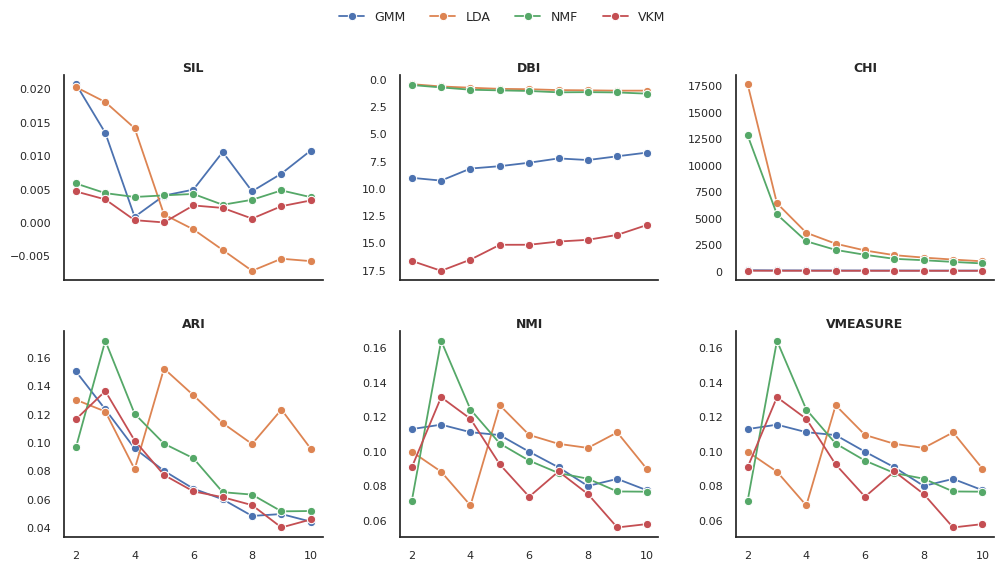

In [83]:
# get indicators
svd = True

comparisons = Clusters_Indicators(cleaned,models=test_models,ml_dct=dct_models,svd=svd)

clear_output()
display(comparisons)
comparison_charts(comparisons,svd=svd)
if not qmd:
    comparisons.to_csv(f'outputs/Indicators_Comparison{'_svd' if svd else ''}.csv')

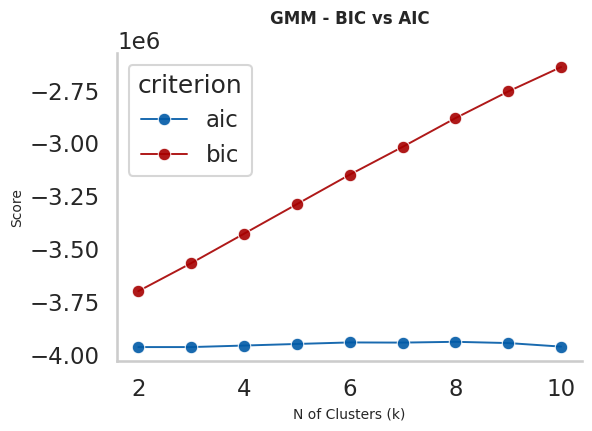

In [96]:
# BIC and AIC GMM
plot_ic(comparisons)

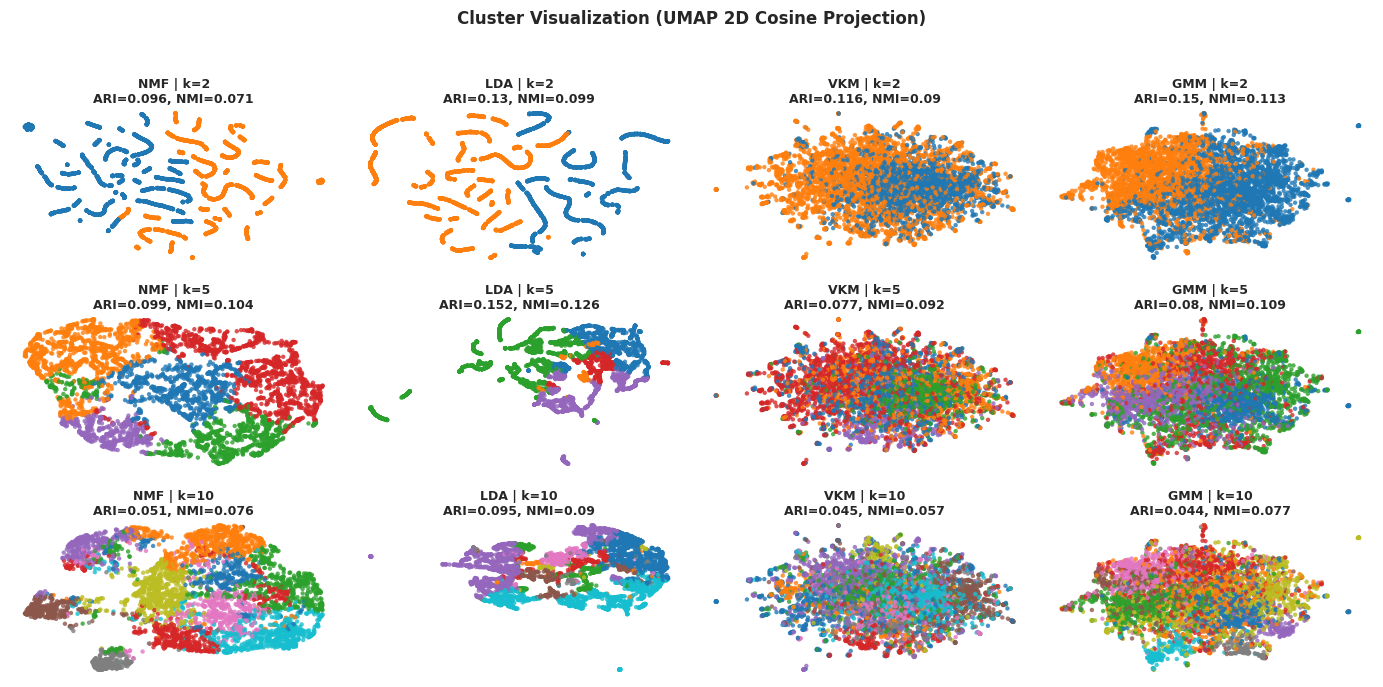

In [70]:
cluster_charts(ml_dct=dct_models,models=test_models,umap_metric ='cosine', svd=svd)

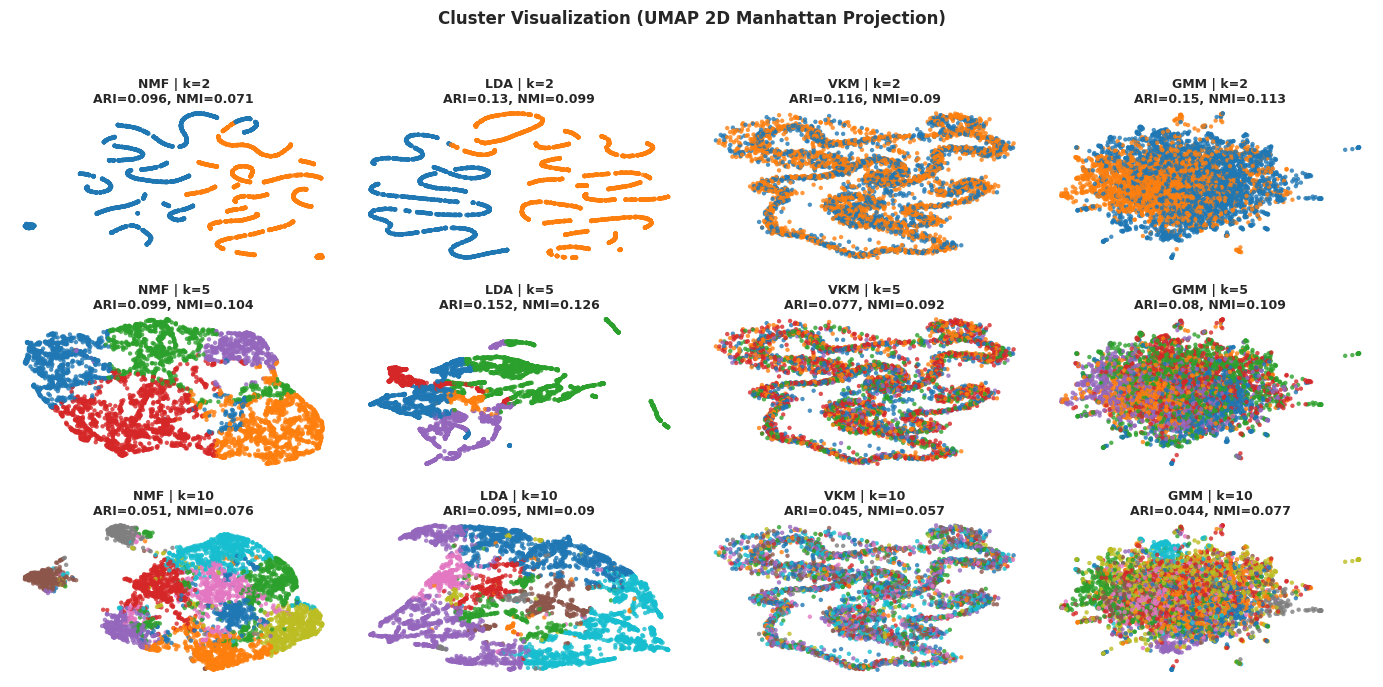

In [71]:
cluster_charts(ml_dct=dct_models,models=test_models,umap_metric ='manhattan', svd=svd)

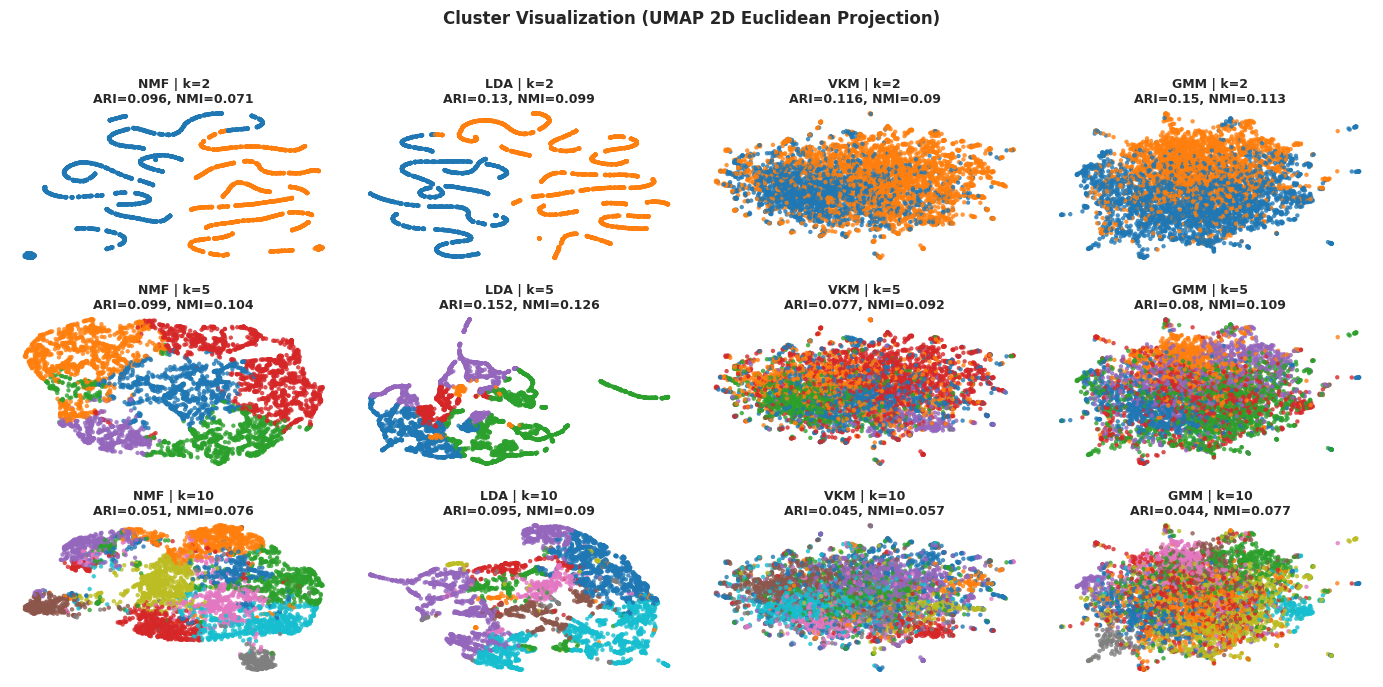

In [72]:
cluster_charts(ml_dct=dct_models,models=test_models,umap_metric ='euclidean', svd=svd)

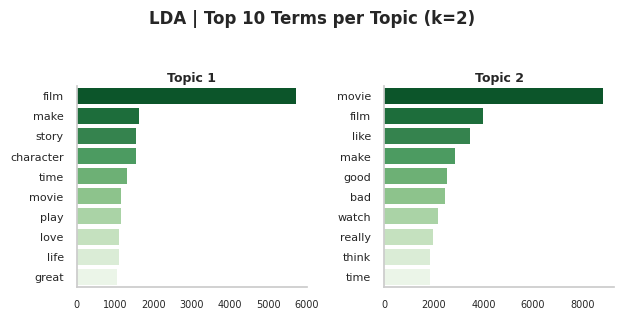

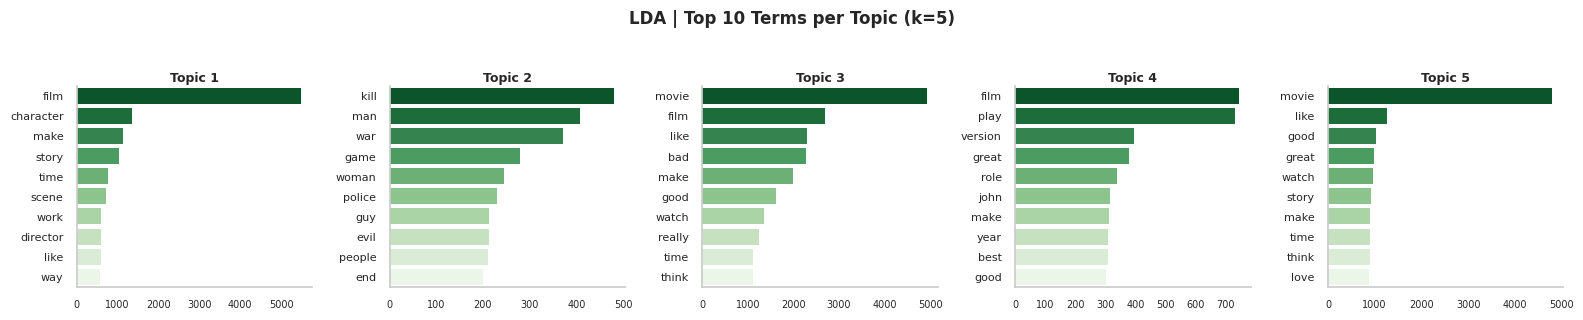

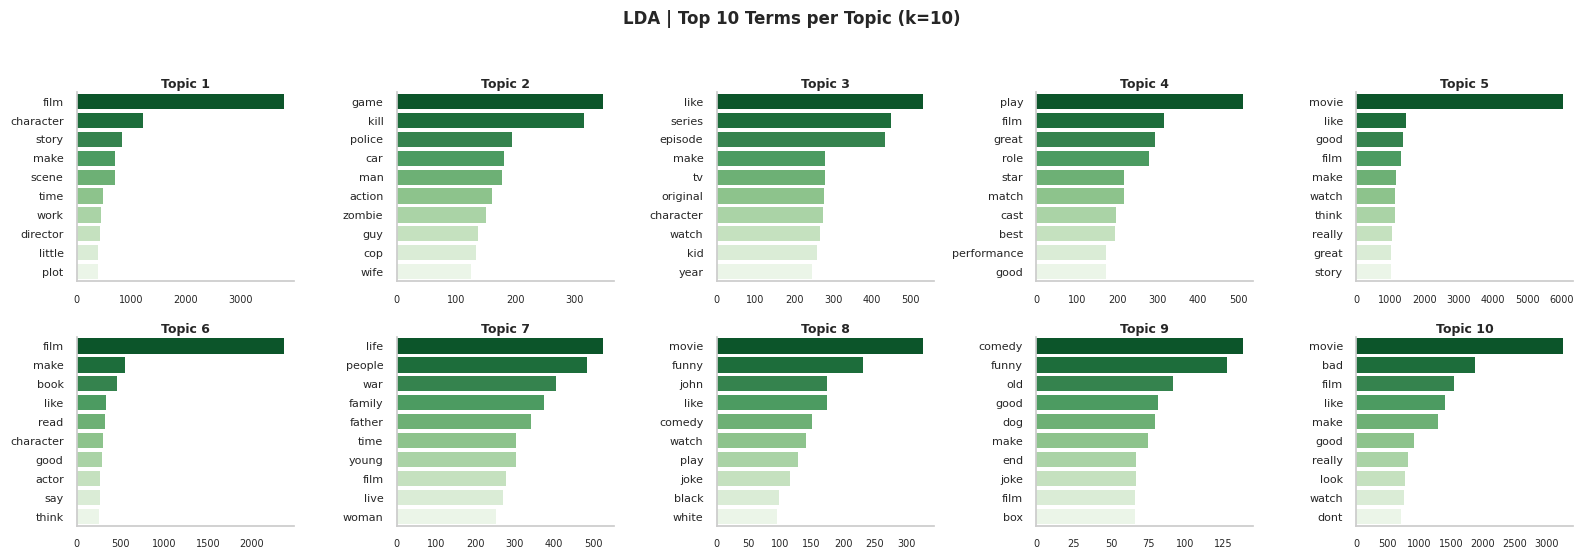

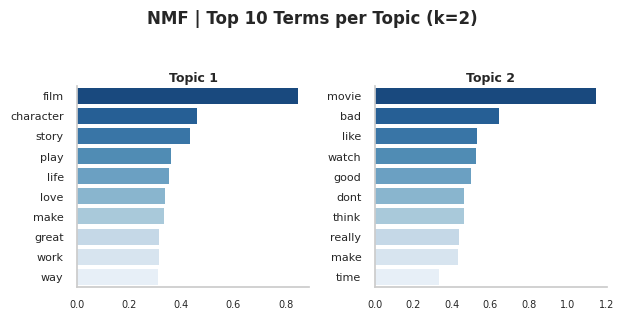

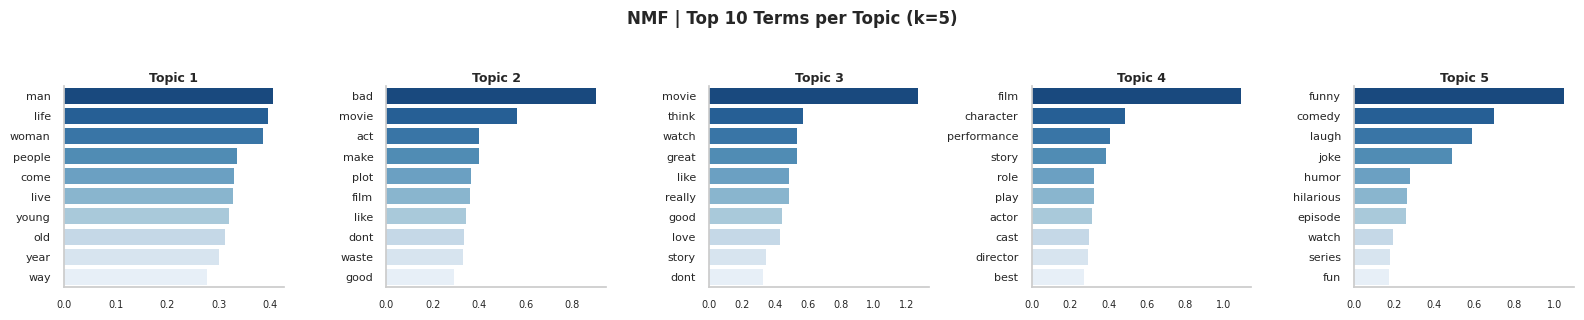

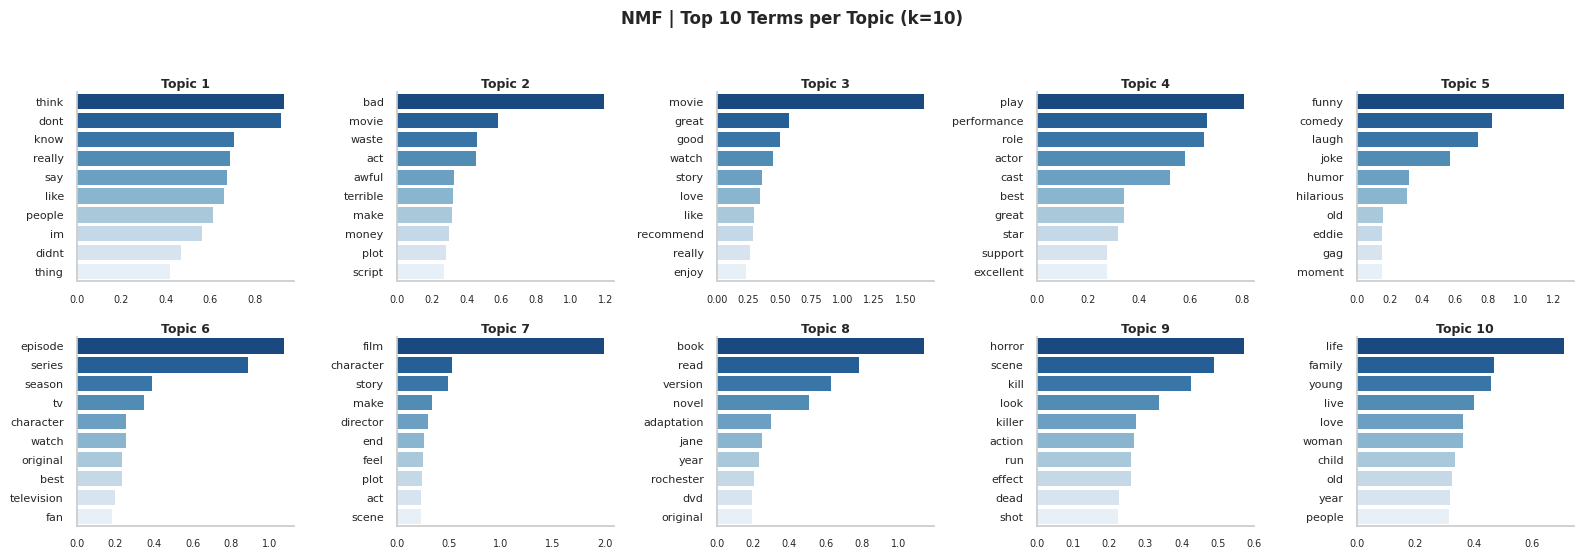

In [ ]:
plot_top_terms(cleaned,dct_models)

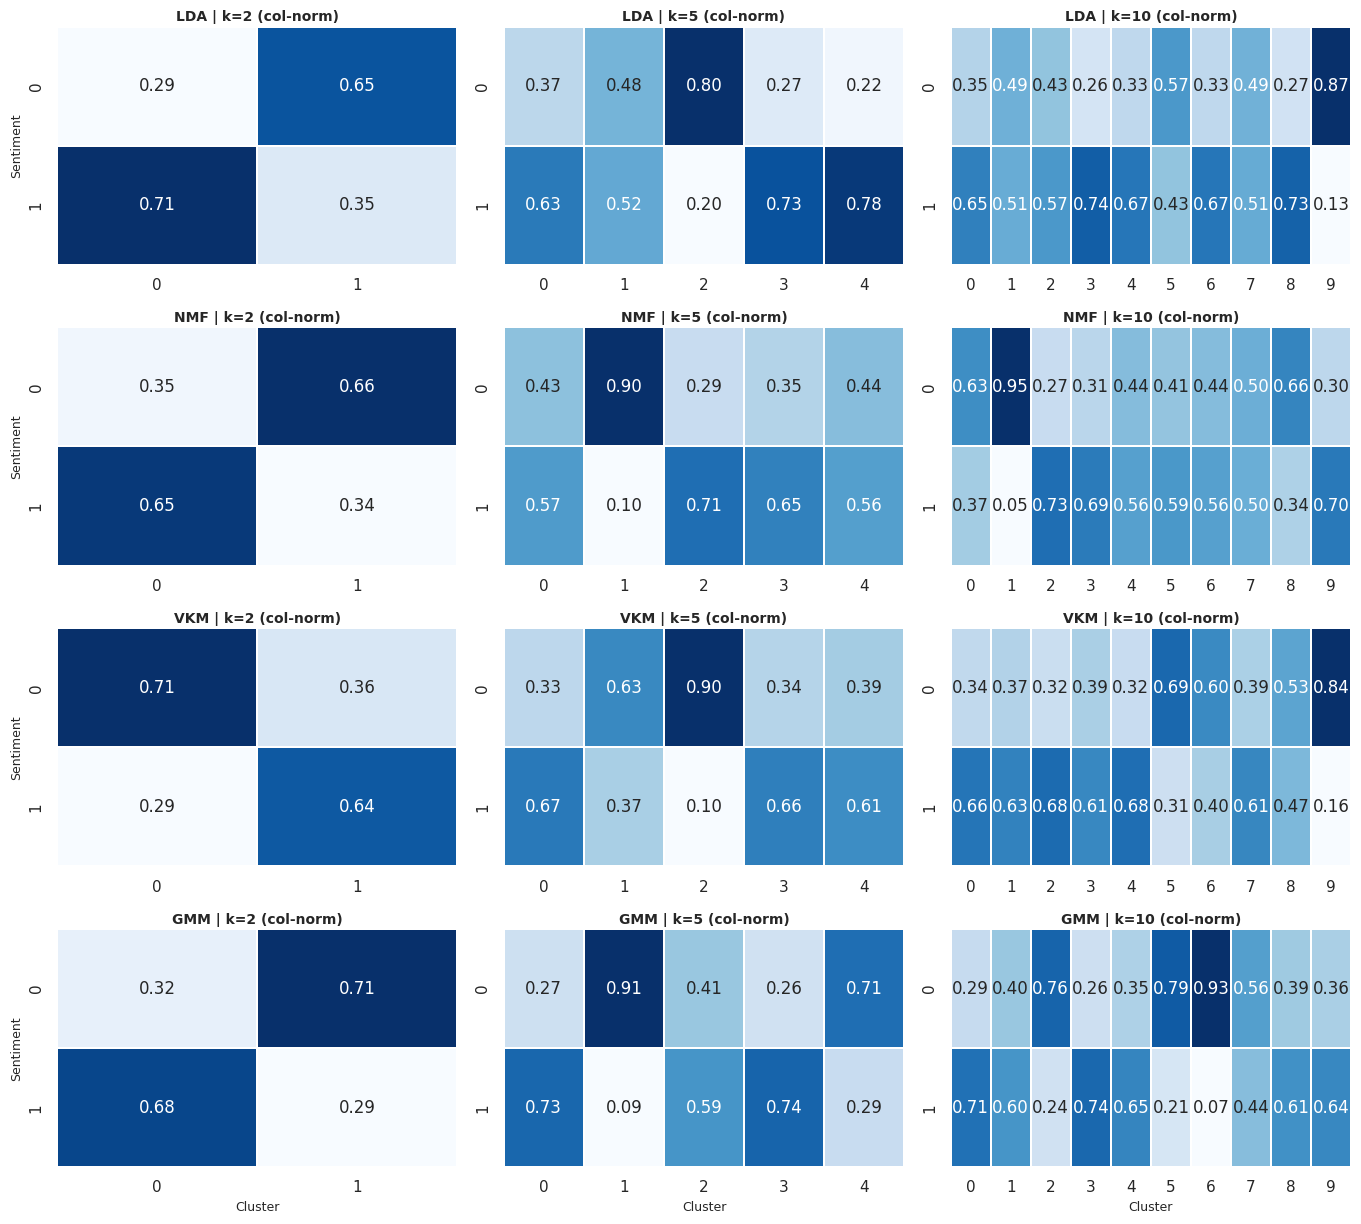

In [122]:

def plot_sentiment_cluster_panel(ml_dct: dict,
                                 models: list = ["LDA","NMF","VKM","GMM"],
                                 k_values: list = [2, 5, 10],
                                 normalize: str = "col",     # "col", "row", or "none"
                                 show_cbar: bool = True,
                                 figsize_per_cell: tuple = (4.6, 3.1),
                                 cmap: str = "Blues") -> None:
    """
    Grid of Sentiment × Cluster heatmaps with models in rows and k in columns.

    Normalisation:
      - "col": column-wise (cluster purity)
      - "row": row-wise
      - "none": raw counts
    """

    sns.set_style("white")
    sns.set_context("notebook")

    n_rows = len(models)
    n_cols = len(k_values)

    # Figure size scales with grid
    fig_w = max(8, figsize_per_cell[0] * n_cols)
    fig_h = max(5, figsize_per_cell[1] * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

    # Track last mappable for a shared colourbar
    last_im = None
    fmt = ".2f" if normalize != "none" else "d"
    ttl_norm = {"col": "col-norm", "row": "row-norm", "none": "counts"}[normalize]

    for r, model in enumerate(models):
        for c, k in enumerate(k_values):
            ax = axes[r, c]
            key = f"{model}_{k}"

            labels = ml_dct[key]["labels"]
            preds  = ml_dct[key]["preds"]

            tab = pd.crosstab(pd.Series(labels, name="sentiment"),
                              pd.Series(preds,  name="cluster")).sort_index(axis=1)

            if normalize == "col":
                denom = tab.sum(axis=0).replace(0, np.nan)
                view = tab.divide(denom, axis=1)
            elif normalize == "row":
                denom = tab.sum(axis=1).replace(0, np.nan)
                view = tab.divide(denom, axis=0)
            else:
                view = tab

            im = sns.heatmap(
                view, cmap=cmap, annot=True, fmt=fmt, cbar=False,
                linewidths=0.25, linecolor="white", ax=ax
            )

            ax.set_title(f"{model} | k={k} ({ttl_norm})", fontsize=10, weight="bold", pad=4)
            ax.set_xlabel("Cluster" if r == n_rows - 1 else "", fontsize=9)
            ax.set_ylabel("Sentiment" if c == 0 else "", fontsize=9)

            # Clean spines
            for sp in ["top","right","left","bottom"]:
                ax.spines[sp].set_visible(False)

    plt.tight_layout()
    plt.savefig("charts/sentiment_cluster_panel.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_sentiment_cluster_panel(dct_models, normalize="col")
